In [1]:
!pip install iterative-stratification

In [2]:
import os
import sys
import datetime
import random
import numpy as np
import pandas as pd
from copy import deepcopy
from tqdm.notebook import tqdm

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
train=pd.read_csv("/kaggle/input/playground-series-s4e3/train.csv")
test=pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv')
sample=pd.read_csv('/kaggle/input/playground-series-s4e3/sample_submission.csv')
original=pd.read_csv('/kaggle/input/faulty-steel-plates/faults.csv')

In [4]:
target_cols=train.iloc[:,-7:].columns.tolist()
target_cols

['Pastry',
 'Z_Scratch',
 'K_Scatch',
 'Stains',
 'Dirtiness',
 'Bumps',
 'Other_Faults']

In [5]:
train=pd.concat([train.drop(columns=['id'],axis=1),original],axis=0)

In [6]:
def feat_eng(df):
    df["X_center"]= (df["X_Minimum"]+df["X_Maximum"])/2
    df["Y_center"]= (df["Y_Minimum"]+df["Y_Maximum"])/2
    df["elongation_index"]=(df['Y_Maximum']-df['Y_Minimum'])/abs(((df['X_Maximum']-df['X_Minimum'])+1e-8))
    df["Rectangularity"]=df["Pixels_Areas"]/(((df["X_Maximum"] - df["X_Minimum"]) * (df["Y_Maximum"] - df["Y_Minimum"]))+1e-8)
    df["Normalized X_Center"]=((df["X_Minimum"]+df["X_Maximum"])/2)/(df["Length_of_Conveyer"]+1e-8)
    df["Normalized Y_Center"]=((df["Y_Minimum"]+df["Y_Maximum"])/2)/(df["Steel_Plate_Thickness"]+1e-8)
    df["Perimeter InteractionA300"]=(df["X_Perimeter"]/(df["Y_Perimeter"])*df["TypeOfSteel_A300"]+1e-8)
    df["Perimeter InteractionA400"]=(df["X_Perimeter"]/(df["Y_Perimeter"])*df["TypeOfSteel_A400"]+1e-8)
    df["log_XtoY_perimeter"]=np.log(df["X_Perimeter"]/df["Y_Perimeter"])
    df["PixelArea_to_Thickness"]=np.log(df["Pixels_Areas"] / (df["Steel_Plate_Thickness"]+1e-8))
    df["Normalized Area"]=df["Pixels_Areas"]/((df["Length_of_Conveyer"]*df["Steel_Plate_Thickness"])+1e-8)
    df["Luminosity Contrast"]=(df["Maximum_of_Luminosity"]-df["Minimum_of_Luminosity"])/(df["Sum_of_Luminosity"]+1e-8)
    df["Density"]=df["Pixels_Areas"]/(((df["X_Maximum"]-df["X_Minimum"])*(df["Y_Maximum"]-df["Y_Minimum"]))+1e-8)
    df["Thickness&Luminosity"]=df["Steel_Plate_Thickness"]* (df["Sum_of_Luminosity"]+1e-8)
    df["Edge_Density"]=(df["Edges_X_Index"]+df["Edges_Y_Index"])/(df["Pixels_Areas"]+1e-8)
    df['Spatial_Distribution_Index'] = df['Edges_Index']+df['Empty_Index']+df['Square_Index']+df['Outside_X_Index']+df['Edges_X_Index']+df['Edges_Y_Index']+df['Outside_Global_Index']
    df['_Color_Range']=df['Maximum_of_Luminosity']-df['Minimum_of_Luminosity']
    df['_Compactness_X']=df['Pixels_Areas']/(df['X_Perimeter']**2)
    df['_Compactness_Y']=df['Pixels_Areas']/(df['Y_Perimeter']**2)
    df['_Normalized_Luminosity_Index'] = df['Luminosity_Index'] / (df['Pixels_Areas']+1e-8)
    df['_Thickness_Steel_Type'] = df['Steel_Plate_Thickness']*(df['TypeOfSteel_A300']+df['TypeOfSteel_A400'])
    return df

In [7]:
feat_eng(train)

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Luminosity Contrast,Density,Thickness&Luminosity,Edge_Density,Spatial_Distribution_Index,_Color_Range,_Compactness_X,_Compactness_Y,_Normalized_Luminosity_Index,_Thickness_Steel_Type
0,584,590,909972,909977,16,8,5,2274,113,140,...,0.011873,0.533333,1.137000e+05,0.125000,3.6452,27,0.250000,0.640000,-0.000650,50
1,808,816,728350,728372,433,20,54,44478,70,111,...,0.000922,2.460227,3.558240e+06,0.002887,3.5775,41,1.082500,0.148491,-0.000692,80
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,...,0.000085,1.094579,5.245564e+07,0.000055,2.3031,112,0.022912,0.064558,-0.000008,40
3,781,789,3353146,3353173,210,16,29,3202,114,134,...,0.006246,0.972222,1.280800e+05,0.006219,3.6972,20,0.820312,0.249703,-0.000191,40
4,1540,1560,618457,618502,521,72,67,48231,82,111,...,0.000601,0.578889,1.446930e+07,0.002297,2.9558,29,0.100502,0.116061,-0.000471,300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,249,277,325780,325796,273,54,22,35033,119,141,...,0.000628,0.609375,1.401320e+06,0.004563,2.5946,22,0.093621,0.564050,0.000010,40
1937,144,175,340581,340598,287,44,24,34599,112,133,...,0.000607,0.544592,1.383960e+06,0.004923,2.6513,21,0.148244,0.498264,-0.000203,40
1938,145,174,386779,386794,292,40,22,37572,120,140,...,0.000532,0.671264,1.502880e+06,0.004818,2.4872,20,0.182500,0.603306,0.000018,40
1939,137,170,422497,422528,419,97,47,52715,117,140,...,0.000436,0.409580,2.108600e+06,0.002386,2.7554,23,0.044532,0.189679,-0.000041,40


In [8]:
feat_eng(test)

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Luminosity Contrast,Density,Thickness&Luminosity,Edge_Density,Spatial_Distribution_Index,_Color_Range,_Compactness_X,_Compactness_Y,_Normalized_Luminosity_Index,_Thickness_Steel_Type
0,19219,1015,1033,3826564,3826588,659,23,46,62357,67,...,0.000962,1.525463,9.353550e+06,0.002375,3.7793,60,1.245747,0.311437,-0.000343,150
1,19220,1257,1271,419960,419973,370,26,28,39293,92,...,0.001018,2.032967,1.571720e+06,0.003355,2.9164,40,0.547337,0.471939,-0.000393,40
2,19221,1358,1372,117715,117724,289,36,32,29386,101,...,0.001123,2.293651,1.175440e+06,0.004671,2.5260,33,0.222994,0.282227,-0.000151,40
3,19222,158,168,232415,232440,80,10,11,8586,107,...,0.003843,0.320000,8.586000e+05,0.022500,4.3991,33,0.800000,0.661157,-0.000922,100
4,19223,559,592,544375,544389,140,19,15,15524,103,...,0.001997,0.303030,9.314400e+05,0.009824,2.9008,31,0.387812,0.622222,-0.000639,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,32028,1101,1116,447943,447992,313,32,37,21603,79,...,0.001111,0.425850,1.512210e+06,0.004235,3.1625,24,0.305664,0.228634,-0.000993,70
12810,32029,1289,1306,3149494,3149542,59,9,18,5249,113,...,0.005334,0.072304,2.099600e+05,0.030132,3.3492,28,0.728395,0.182099,-0.000759,40
12811,32030,41,210,1587535,1587191,16584,796,522,1858162,24,...,0.000064,-0.285262,7.432648e+07,0.000038,2.3104,119,0.026174,0.060862,-0.000005,40
12812,32031,1329,1340,702237,702267,386,43,34,36875,66,...,0.001573,1.169697,1.475000e+06,0.003214,2.5988,58,0.208761,0.333910,-0.000681,40


In [9]:
X=train.drop(columns=target_cols,axis=1)
y1=train.loc[:,target_cols[0]]

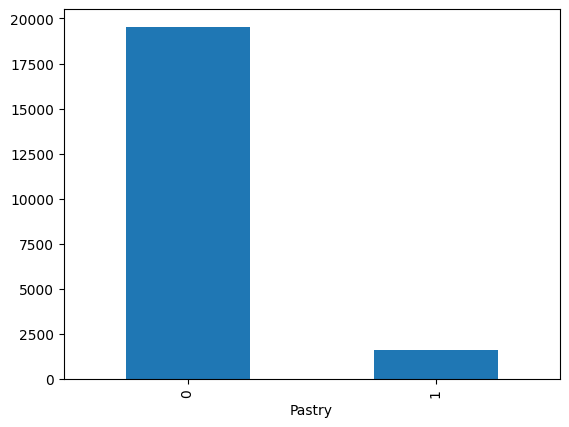

In [10]:
y1.value_counts().plot(kind="bar");

In [11]:
y2=train.loc[:,target_cols[1]]
y3=train.loc[:,target_cols[2]]
y4=train.loc[:,target_cols[3]]
y5=train.loc[:,target_cols[4]]
y6=train.loc[:,target_cols[5]]
y7=train.loc[:,target_cols[6]]

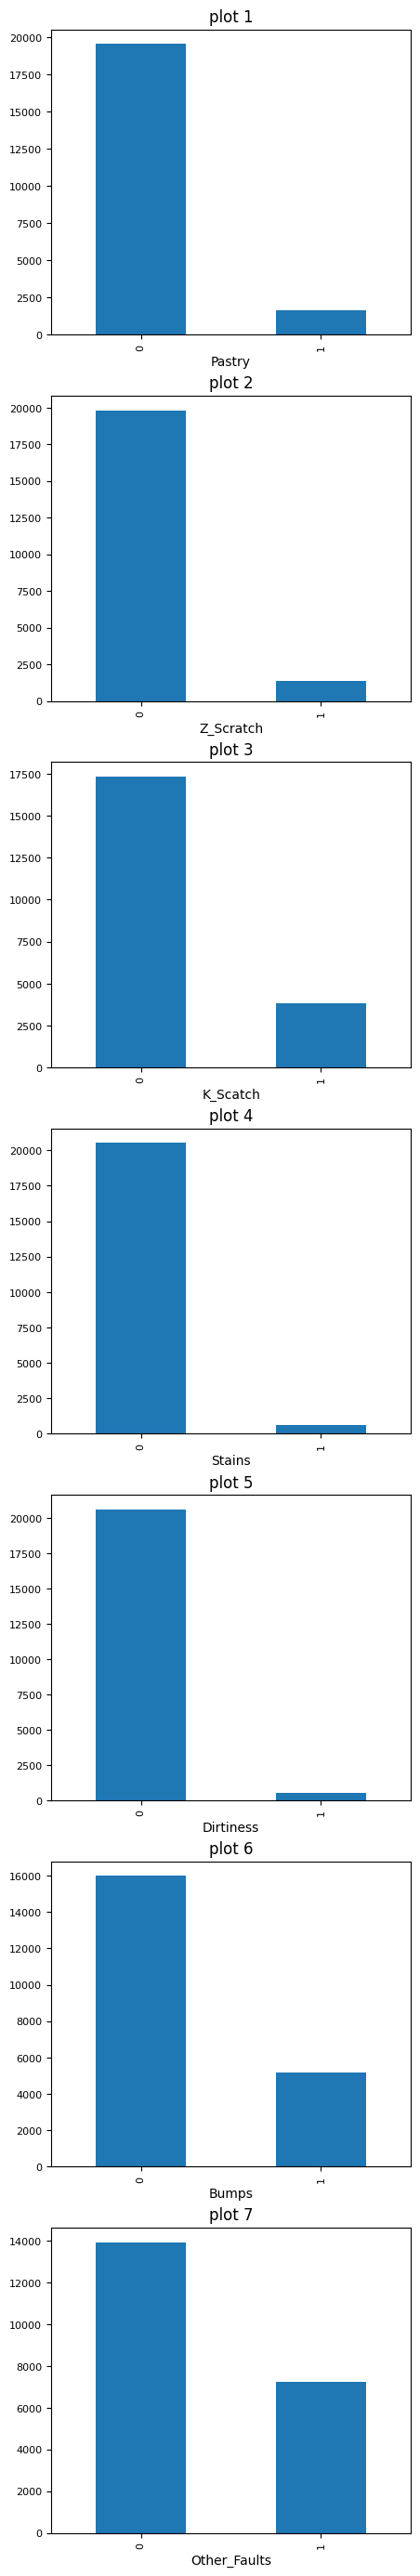

In [12]:
fig,axes=plt.subplots(7,1,figsize=(5,35))
for j,target in enumerate([y1,y2,y3,y4,y5,y6,y7]):
    target.value_counts().plot(kind='bar',title=f"plot {j+1}",ax=axes[j],fontsize=8);

plt.show()

In [13]:
class TabularData(Dataset):
    def __init__(self,x_tensor,y_tensor):
        self.x=x_tensor
        self.y=y_tensor

    def __getitem__(self, index):
        return (self.x[index],self.y[index])
    
    def __len__(self):
        return len(self.x)

In [14]:
class Goodclass(object):
    def __init__(self,model,loss_fn,optimizer,es_patience=5):
        # arguments
        self.model=model
        self.loss_fn=loss_fn
        self.optimizer=optimizer
        self.device='cuda:0' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

        # to be used in future (Cuerrently empty)
        self.train_loader=None
        self.val_loader=None
        
        # for early stoppper
        self.patience=es_patience
        self.min_delta=0
        self.counter=0
        self.min_validation_loss=float('inf')

        # computes internally
        self.losses=[]
        self.val_losses=[]
        self.total_epochs=0

        # step functions
        self.train_step_fn=self._make_train_step_fn()
        self.val_step_fn=self._make_val_step_fn()
        
    def _should_early_stop(self,val_loss):
        if val_loss<self.min_validation_loss:
            self.min_validation_loss=val_loss
            counter=0
        else:
            self.counter+=1
            if self.counter>=self.patience:
                return True
        return False
            

    def to(self,device):
        try:
            self.device=device
            self.model.to(self.device)
        except RuntimeError:
            self.device='cuda:0' if torch.cuda.is_available else 'cpu'
            print(f"Can't send to {device}, moving to {self.device} instead!")
            self.model.to(self.device)

    def set_loaders(self,train_loader,val_loader=None):
        self.train_loader=train_loader
        self.val_loader=val_loader

    def _make_train_step_fn(self):
        def perform_train_step_fn(X,y):
            # set model to train mode
            self.model.train()
            # forward pass
            yhat=self.model(X)
            # compute losses
            loss=self.loss_fn(yhat,y)
            # compute gradients
            loss.backward()
            # update parameters
            self.optimizer.step()
            self.optimizer.zero_grad()

            
            return loss.item()
        return perform_train_step_fn

    def _make_val_step_fn(self):
        def perform_val_step(X,y):
            # set model to eval mode
            self.model.eval()
            # forward pass
            yhat=self.model(X)
            # loss calculation
            loss=self.loss_fn(yhat,y)


            return loss.item()
        return perform_val_step
    
    def _mini_batch(self,validation=False):
        if validation:
            data_loader=self.val_loader
            step_fn=self.val_step_fn

        else:
            data_loader=self.train_loader
            step_fn=self.train_step_fn

        if data_loader is None:
            return None
        
        mini_batch_losses=[]
        mini_batch_scores=[]
        for X_batch,y_batch in data_loader:
            X_batch=X_batch.to(self.device)
            y_batch=y_batch.to(self.device)

            mini_batch_loss=step_fn(X_batch,y_batch)
            mini_batch_losses.append(mini_batch_loss)


        return np.mean(mini_batch_losses)
    
    def set_seed(self,seed=42):
        torch.backends.cudnn.deterministic=True
        torch.backends.cudnn.benchmark=False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self,n_epochs,seed=42):
        self.set_seed(seed)
        for epoch in tqdm(range(n_epochs)):
            self.total_epochs+=1
            # perform training using mini batches
            loss=self._mini_batch(validation=False)
            self.losses.append(loss)

            # perform validation using mini batches
            with torch.no_grad():
                val_loss=self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
                if self._should_early_stop(val_loss):
                    print("early stopping")
                    break

    def predict(self,X):
        self.model.eval()
        X_tensor=torch.as_tensor(X,dtype=torch.float32,device=self.device)
        yhat_tensor=self.model(X_tensor)
        self.model.train()
        return yhat_tensor.detach().cpu().numpy()
    
    def plot_figures(self):
        fig,ax=plt.subplots(figsize=(10,4))
        ax.plot(self.losses,label='training loss',c='b')
        ax.plot(self.val_losses,label='validation loss',c='r')
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Losses")
        ax.legend()
        plt.tight_layout()
        plt.show()
        





In [15]:
class TabularNetDeep(nn.Module):
    def __init__(self,p,input_shape,output_shape):
        super(TabularNetDeep,self).__init__()
        self.p=p
        self.input_shape=input_shape
        self.output_shape=output_shape

        self.feature_extractor=nn.Sequential(
            nn.Linear(input_shape,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(self.p),
            
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(self.p),
            
            nn.Linear(1024,256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(self.p),
            
            nn.Linear(256,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.p),
            
            nn.Linear(64,48),
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Dropout(self.p))
        
        self.classifier=nn.Sequential(
            nn.Linear(48,output_shape),
            nn.Sigmoid())
        
    def forward(self,x):
        x=self.feature_extractor(x)
        x=self.classifier(x)
        return x
        
        
        
          

In [16]:
def make_data_loader(X_train,X_val,y_train,y_val):

    # Standardizing Data
    std_scaler=StandardScaler()
    X_train_scaled=std_scaler.fit_transform(X_train)
    X_val_scaled=std_scaler.transform(X_val)

    # creating tensors
    X_train_tensor,y_train_tensor=torch.as_tensor(X_train_scaled,dtype=torch.float32),torch.as_tensor(y_train,dtype=torch.float32)
    X_val_tensor,y_val_tensor=torch.as_tensor(X_val_scaled,dtype=torch.float32),torch.as_tensor(y_val,dtype=torch.float32)

    train_dataset=TabularData(X_train_tensor,y_train_tensor)
    val_dataset=TabularData(X_val_tensor,y_val_tensor)

    train_loader=DataLoader(train_dataset,batch_size=256,num_workers=4,pin_memory=True,shuffle=True)
    val_loader=DataLoader(val_dataset,batch_size=256,num_workers=4,pin_memory=True)
    return train_loader,val_loader

In [17]:
# Standardizing Data
std_scaler=StandardScaler()
X_scaled=std_scaler.fit_transform(X)


## for y7

In [18]:
y7=np.array(y7).reshape(-1,1)

In [19]:
skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

def mean_loss7():
    mean_val_losses=[]
    oof_preds=[]
    # perform cross validation
    for train_idx, val_idx in skf.split(X_scaled,y7):
        X_train,y_train=X_scaled[train_idx],y7[train_idx]
        X_val,y_val=X_scaled[val_idx],y7[val_idx]

        train_loader,val_loader=make_data_loader(X_train,X_val,y_train,y_val)
        model=TabularNetDeep(p=0.3,input_shape=48,output_shape=1)
        optimizer=optim.Adam(model.parameters(),lr=1.01e-2)
        scheduler=StepLR(optimizer,step_size=10,gamma=0.1)
        loss_fn=nn.BCELoss(reduction='mean')

        AnuwazNet=Goodclass(model,loss_fn,optimizer,es_patience=10)
        AnuwazNet.set_loaders(train_loader,val_loader)
        AnuwazNet.train(100)
        print(f"Min val loss: {np.min(AnuwazNet.val_losses)}\tFinal val loss: {AnuwazNet.val_losses[-1]}")
        mean_val_losses.append(AnuwazNet.val_losses[-3:])
        oof_preds.append(AnuwazNet.predict(std_scaler.transform(test.drop(columns=['id']))))
    
    return np.mean(mean_val_losses),oof_preds

In [20]:
mean_validation_loss7, OOF_predictions7=mean_loss7()

  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.58211835887697	Final val loss: 0.5859681434101529


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.607462743918101	Final val loss: 0.6095997956064012


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.5816007918781705	Final val loss: 0.5896407763163248


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.6043477654457092	Final val loss: 0.6097151140371958


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.5892792310979631	Final val loss: 0.5897599988513522


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.5924233727984958	Final val loss: 0.5928498109181722


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.5919415487183465	Final val loss: 0.5976144903235965


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.5832185414102342	Final val loss: 0.5908043086528778


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.5808456308311887	Final val loss: 0.5847014453676012


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.5857807861434089	Final val loss: 0.5983862148390876


In [21]:
mean_validation_loss7

0.5937301095989015

0.5950115544928444

In [22]:
y7_preds=np.mean(np.array(OOF_predictions7),axis=0)

In [23]:
y7_preds

array([[0.29811552],
       [0.34326574],
       [0.5046548 ],
       ...,
       [0.1018015 ],
       [0.2976882 ],
       [0.0581022 ]], dtype=float32)

## for y6

In [24]:
y6=np.array(y6).reshape(-1,1)

In [25]:
skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

def mean_loss6():
    mean_val_losses=[]
    oof_preds=[]
    # perform cross validation
    for train_idx, val_idx in skf.split(X_scaled,y6):
        X_train,y_train=X_scaled[train_idx],y6[train_idx]
        X_val,y_val=X_scaled[val_idx],y6[val_idx]

        train_loader,val_loader=make_data_loader(X_train,X_val,y_train,y_val)
        model=TabularNetDeep(p=0.3,input_shape=48,output_shape=1)
        optimizer=optim.Adam(model.parameters(),lr=1.01e-2)
        scheduler=StepLR(optimizer,step_size=10,gamma=0.1)
        loss_fn=nn.BCELoss(reduction='mean')

        AnuwazNet=Goodclass(model,loss_fn,optimizer,es_patience=10)
        AnuwazNet.set_loaders(train_loader,val_loader)
        AnuwazNet.train(100)
        print(f"Min val loss: {np.min(AnuwazNet.val_losses)}\tFinal val loss: {AnuwazNet.val_losses[-1]}")
        mean_val_losses.append(AnuwazNet.val_losses[-3:])
        oof_preds.append(AnuwazNet.predict(std_scaler.transform(test.drop(columns=['id']))))
    
    return np.mean(mean_val_losses),oof_preds

In [26]:
mean_validation_loss6, OOF_predictions6=mean_loss6()

  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.43341953224605984	Final val loss: 0.434943825006485


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.44297561711735195	Final val loss: 0.4436330431037479


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.4368797606892056	Final val loss: 0.4424208568202125


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.4198494387997521	Final val loss: 0.42455160948965287


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.42018427782588536	Final val loss: 0.42501776417096454


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.4332793785466088	Final val loss: 0.4385238587856293


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.4257078568140666	Final val loss: 0.4295644263426463


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.42594988809691536	Final val loss: 0.43076054255167645


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.41492680377430385	Final val loss: 0.41693929003344643


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.43535586529307896	Final val loss: 0.4375136064158546


In [27]:
mean_validation_loss6

0.4321126995263277

In [28]:
y6_preds=np.mean(np.array(OOF_predictions6),axis=0)

In [29]:
y6_preds

array([[1.90390304e-01],
       [1.14609584e-01],
       [2.89231747e-01],
       ...,
       [9.85545776e-05],
       [1.12832285e-01],
       [2.01033632e-04]], dtype=float32)

## for y5

In [30]:
y5=np.array(y5).reshape(-1,1)

In [31]:
skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

def mean_loss5():
    mean_val_losses=[]
    oof_preds=[]
    # perform cross validation
    for train_idx, val_idx in skf.split(X_scaled,y5):
        X_train,y_train=X_scaled[train_idx],y5[train_idx]
        X_val,y_val=X_scaled[val_idx],y5[val_idx]

        train_loader,val_loader=make_data_loader(X_train,X_val,y_train,y_val)
        model=TabularNetDeep(p=0.3,input_shape=48,output_shape=1)
        optimizer=optim.Adam(model.parameters(),lr=1.01e-2)
        scheduler=StepLR(optimizer,step_size=10,gamma=0.1)
        loss_fn=nn.BCELoss(reduction='mean')

        AnuwazNet=Goodclass(model,loss_fn,optimizer,es_patience=10)
        AnuwazNet.set_loaders(train_loader,val_loader)
        AnuwazNet.train(100)
        print(f"Min val loss: {np.min(AnuwazNet.val_losses)}\tFinal val loss: {AnuwazNet.val_losses[-1]}")
        mean_val_losses.append(AnuwazNet.val_losses[-3:])
        oof_preds.append(AnuwazNet.predict(std_scaler.transform(test.drop(columns=['id']))))
    
    return np.mean(mean_val_losses),oof_preds

In [32]:
mean_validation_loss5, OOF_predictions5=mean_loss5()

  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.07583425359593497	Final val loss: 0.07935911458399561


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.08054552713616027	Final val loss: 0.08449727959103054


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.08209328208532599	Final val loss: 0.08417010948889786


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.08002660961614715	Final val loss: 0.08221447167711125


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.07932302024629381	Final val loss: 0.0809064648217625


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.0818917519516415	Final val loss: 0.08261881437566546


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.0790395134439071	Final val loss: 0.08386908430192205


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.07815123349428177	Final val loss: 0.08780071263511975


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.07861845381557941	Final val loss: 0.08327798793713252


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.07642667864759763	Final val loss: 0.08179576363828447


In [33]:
mean_validation_loss5

0.08246990692008425

In [34]:
y5_preds=np.mean(np.array(OOF_predictions5),axis=0)

In [35]:
y5_preds

array([[2.6724864e-02],
       [1.4528130e-01],
       [6.9915010e-03],
       ...,
       [9.4434999e-06],
       [6.1999928e-02],
       [6.0497121e-05]], dtype=float32)

## for y4

In [36]:
y4=np.array(y4).reshape(-1,1)

In [37]:
skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

def mean_loss4():
    mean_val_losses=[]
    oof_preds=[]
    # perform cross validation
    for train_idx, val_idx in skf.split(X_scaled,y4):
        X_train,y_train=X_scaled[train_idx],y4[train_idx]
        X_val,y_val=X_scaled[val_idx],y4[val_idx]

        train_loader,val_loader=make_data_loader(X_train,X_val,y_train,y_val)
        model=TabularNetDeep(p=0.3,input_shape=48,output_shape=1)
        optimizer=optim.Adam(model.parameters(),lr=1.01e-2)
        scheduler=StepLR(optimizer,step_size=10,gamma=0.1)
        loss_fn=nn.BCELoss(reduction='mean')

        AnuwazNet=Goodclass(model,loss_fn,optimizer,es_patience=10)
        AnuwazNet.set_loaders(train_loader,val_loader)
        AnuwazNet.train(100)
        print(f"Min val loss: {np.min(AnuwazNet.val_losses)}\tFinal val loss: {AnuwazNet.val_losses[-1]}")
        mean_val_losses.append(AnuwazNet.val_losses[-3:])
        oof_preds.append(AnuwazNet.predict(std_scaler.transform(test.drop(columns=['id']))))
    
    return np.mean(mean_val_losses),oof_preds

In [38]:
mean_validation_loss4, OOF_predictions4=mean_loss4()

  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.03572386565307776	Final val loss: 0.03675123324824704


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.03727706604533725	Final val loss: 0.037800054997205734


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.024541993263281055	Final val loss: 0.027913557055095833


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.029829862501679197	Final val loss: 0.030785215087234974


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.03489286509445972	Final val loss: 0.04455329570919275


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.036434908914897174	Final val loss: 0.037090529998143516


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.042502099389417305	Final val loss: 0.04818330115328232


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.03098759251750178	Final val loss: 0.03334716231458717


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.04204763161639372	Final val loss: 0.04430424359937509


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.036049569956958294	Final val loss: 0.037859267619852394


In [39]:
mean_validation_loss4

0.03840481050989452

In [40]:
y4_preds=np.mean(np.array(OOF_predictions4),axis=0)

In [41]:
y4_preds

array([[2.8444618e-05],
       [4.9160481e-05],
       [6.2085880e-04],
       ...,
       [1.2919951e-06],
       [2.3648852e-05],
       [2.4604840e-05]], dtype=float32)

## for y3

In [42]:
y3=np.array(y3).reshape(-1,1)

In [43]:
skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

def mean_loss3():
    mean_val_losses=[]
    oof_preds=[]
    # perform cross validation
    for train_idx, val_idx in skf.split(X_scaled,y3):
        X_train,y_train=X_scaled[train_idx],y3[train_idx]
        X_val,y_val=X_scaled[val_idx],y3[val_idx]

        train_loader,val_loader=make_data_loader(X_train,X_val,y_train,y_val)
        model=TabularNetDeep(p=0.3,input_shape=48,output_shape=1)
        optimizer=optim.Adam(model.parameters(),lr=1.01e-2)
        scheduler=StepLR(optimizer,step_size=10,gamma=0.1)
        loss_fn=nn.BCELoss(reduction='mean')

        AnuwazNet=Goodclass(model,loss_fn,optimizer,es_patience=10)
        AnuwazNet.set_loaders(train_loader,val_loader)
        AnuwazNet.train(100)
        print(f"Min val loss: {np.min(AnuwazNet.val_losses)}\tFinal val loss: {AnuwazNet.val_losses[-1]}")
        mean_val_losses.append(AnuwazNet.val_losses[-3:])
        oof_preds.append(AnuwazNet.predict(std_scaler.transform(test.drop(columns=['id']))))
    
    return np.mean(mean_val_losses),oof_preds

In [44]:
mean_validation_loss3, OOF_predictions3=mean_loss3()

  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.11197150395148331	Final val loss: 0.11563545010156101


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.11071132206254536	Final val loss: 0.11316335408224


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.10758297683464156	Final val loss: 0.11019094371133381


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.1057733264234331	Final val loss: 0.10710460402899319


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.09657464052240054	Final val loss: 0.09932918205029434


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.12682700819439358	Final val loss: 0.13463750605781874


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.10648651503854328	Final val loss: 0.11149487354689175


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.1140682813194063	Final val loss: 0.11470863636997011


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.11251347098085615	Final val loss: 0.11688085314300325


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.08199648559093475	Final val loss: 0.09586381912231445


In [45]:
mean_validation_loss3

0.11118884586763603

In [46]:
y3_preds=np.mean(np.array(OOF_predictions3),axis=0)

In [47]:
y3_preds

array([[1.2821799e-04],
       [6.1369683e-03],
       [5.9152603e-02],
       ...,
       [9.0246248e-01],
       [2.1033393e-02],
       [9.1607112e-01]], dtype=float32)

## for y2

In [48]:
y2=np.array(y2).reshape(-1,1)

In [49]:
skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

def mean_loss2():
    mean_val_losses=[]
    oof_preds=[]
    # perform cross validation
    for train_idx, val_idx in skf.split(X_scaled,y2):
        X_train,y_train=X_scaled[train_idx],y2[train_idx]
        X_val,y_val=X_scaled[val_idx],y2[val_idx]

        train_loader,val_loader=make_data_loader(X_train,X_val,y_train,y_val)
        model=TabularNetDeep(p=0.3,input_shape=48,output_shape=1)
        optimizer=optim.Adam(model.parameters(),lr=1.01e-2)
        scheduler=StepLR(optimizer,step_size=10,gamma=0.1)
        loss_fn=nn.BCELoss(reduction='mean')

        AnuwazNet=Goodclass(model,loss_fn,optimizer,es_patience=10)
        AnuwazNet.set_loaders(train_loader,val_loader)
        AnuwazNet.train(100)
        print(f"Min val loss: {np.min(AnuwazNet.val_losses)}\tFinal val loss: {AnuwazNet.val_losses[-1]}")
        mean_val_losses.append(AnuwazNet.val_losses[-3:])
        oof_preds.append(AnuwazNet.predict(std_scaler.transform(test.drop(columns=['id']))))
    
    return np.mean(mean_val_losses),oof_preds

In [50]:
mean_validation_loss2, OOF_predictions2=mean_loss2()

  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.12977211591270235	Final val loss: 0.12998308738072714


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.1156992916431692	Final val loss: 0.12292153015732765


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.10825229394767019	Final val loss: 0.11216675862669945


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.11962297103471226	Final val loss: 0.1215750782026185


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.11784361178676288	Final val loss: 0.1202678353422218


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.11141345649957657	Final val loss: 0.1138173279662927


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.1085631793571843	Final val loss: 0.11016302059094112


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.11577862749497096	Final val loss: 0.11699646876917945


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.11526959886153539	Final val loss: 0.11842457950115204


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.11778256379895741	Final val loss: 0.11919443060954411


In [51]:
mean_validation_loss2

0.11787607159327579

In [52]:
y2_preds=np.mean(np.array(OOF_predictions2),axis=0)

In [53]:
y2_preds

array([[9.1538636e-04],
       [5.6076497e-03],
       [2.9000793e-02],
       ...,
       [2.9586101e-05],
       [1.4609419e-03],
       [3.3732230e-04]], dtype=float32)

In [54]:
y1=np.array(y1).reshape(-1,1)

In [55]:
skf=StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

def mean_loss1():
    mean_val_losses=[]
    oof_preds=[]
    # perform cross validation
    for train_idx, val_idx in skf.split(X_scaled,y1):
        X_train,y_train=X_scaled[train_idx],y1[train_idx]
        X_val,y_val=X_scaled[val_idx],y1[val_idx]

        train_loader,val_loader=make_data_loader(X_train,X_val,y_train,y_val)
        model=TabularNetDeep(p=0.3,input_shape=48,output_shape=1)
        optimizer=optim.Adam(model.parameters(),lr=1.01e-2)
        scheduler=StepLR(optimizer,step_size=10,gamma=0.1)
        loss_fn=nn.BCELoss(reduction='mean')

        AnuwazNet=Goodclass(model,loss_fn,optimizer,es_patience=10)
        AnuwazNet.set_loaders(train_loader,val_loader)
        AnuwazNet.train(100)
        print(f"Min val loss: {np.min(AnuwazNet.val_losses)}\tFinal val loss: {AnuwazNet.val_losses[-1]}")
        mean_val_losses.append(AnuwazNet.val_losses[-3:])
        oof_preds.append(AnuwazNet.predict(std_scaler.transform(test.drop(columns=['id']))))
    
    return np.mean(mean_val_losses),oof_preds

In [56]:
mean_validation_loss1, OOF_predictions1=mean_loss1()

  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.20272776070568296	Final val loss: 0.20383934014373356


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.18414420220586988	Final val loss: 0.18603603624635273


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.18680374407105976	Final val loss: 0.18908788677718905


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.179067795475324	Final val loss: 0.18882465859254202


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.18547189484039941	Final val loss: 0.19204395016034445


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.18467848582400215	Final val loss: 0.1866499665710661


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.18373815135823357	Final val loss: 0.18664765192402732


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.19443908664915296	Final val loss: 0.1945130146212048


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.18217418839534125	Final val loss: 0.18659445312288073


  0%|          | 0/100 [00:00<?, ?it/s]

early stopping
Min val loss: 0.19335894286632538	Final val loss: 0.1983243020044433


In [57]:
mean_validation_loss1

0.19144771097710836

In [58]:
y1_preds=np.mean(np.array(OOF_predictions1),axis=0)

In [59]:
y1_preds

array([[4.1480207e-01],
       [3.4177172e-01],
       [1.8102800e-03],
       ...,
       [2.5077100e-07],
       [4.1123566e-01],
       [5.6932709e-05]], dtype=float32)

In [60]:
preds_list=[y1_preds,y2_preds,y3_preds,y4_preds,y5_preds,y6_preds,y7_preds]
for col,val in zip(target_cols,preds_list):
    sample[col]=val

In [61]:
sample.to_csv("submission.csv",index=False)

In [62]:
sample


,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,4.148021e-01,0.000915,0.000128,0.000028,0.026725,0.190390,0.298116
1,19220,3.417717e-01,0.005608,0.006137,0.000049,0.145281,0.114610,0.343266
2,19221,1.810280e-03,0.029001,0.059153,0.000621,0.006992,0.289232,0.504655
3,19222,1.326415e-01,0.001593,0.000018,0.000944,0.009338,0.435545,0.454565
4,19223,9.309248e-04,0.000412,0.000073,0.000195,0.008778,0.561706,0.407267
...,...,...,...,...,...,...,...,...
12809,32028,1.343157e-01,0.089889,0.005250,0.000017,0.064861,0.232939,0.323400
12810,32029,1.747096e-01,0.001214,0.021637,0.005704,0.317628,0.191989,0.382534
12811,32030,2.507710e-07,0.000030,0.902462,0.000001,0.000009,0.000099,0.101801
12812,32031,4.112357e-01,0.001461,0.021033,0.000024,0.062000,0.112832,0.297688
